## 1D Convolutional Neural Network (CNN) with GloVe embeddings for hate speech detection ##

### Instructions

The data for the competition has been pre-partitioned into 3 sets: train,dev,test

The test data consists of two parts: public and private, the leaderboard will display the performance<br>
on the public part, and we will announce the final results on the private test set after 04/12/2024.<br>

*Files*

    train_2024.csv - the training set, 99000 rows
    dev_2024.csv - the development set, 11000 rows
    test_2024.csv - the test set, 12001 rows
    sample_submission_2024.csv - a sample submission file in the correct format

*Columns*

    id - column for the example_id within the set
    text - the text of the comment
    label - binary label (1=Toxic/0=NonToxic)


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os


In [4]:

import matplotlib.pyplot as plt
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight

### Check is GPU available

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Running with %s, %d GPU available.' % (device, torch.cuda.device_count()))
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU detected! use colab or some other env')

Running with cuda, 1 GPU available.
GPU: Tesla T4


In [10]:
df = pd.read_csv("nlp_proj/train/train_2024.csv", quoting=3, index_col=0)

# uncomm below if you want to combine train and dev sets (train test split do the split)
#df_dev = pd.read_csv("./dev/dev_2024.csv", quoting=3, index_col=0)   #dev set
#df = pd.concat([df, df_dev])

df.reset_index(drop=True, inplace=True)
df.head(3)

,text,label
0,Except that Desmond played first base last nig...,0
1,What i find funny is the loyalty and blindness...,0
2,Read the article not just the headline & you ...,0


In [12]:
pd.set_option('display.max_colwidth', 100)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99000 entries, 0 to 98999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    99000 non-null  object
 1   label   99000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


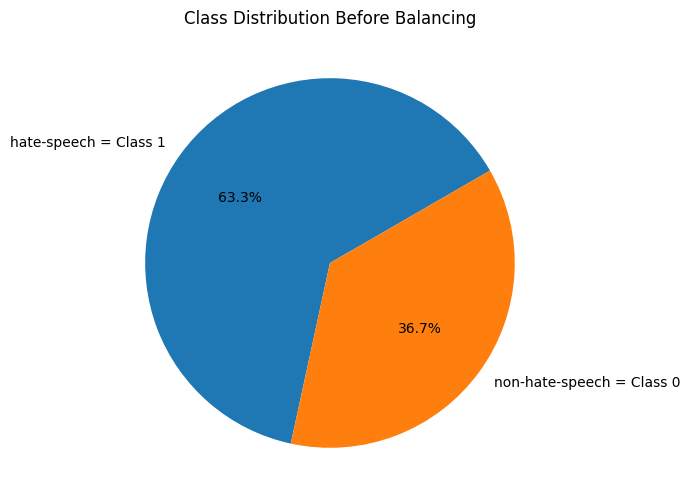

In [13]:

# let's visualize the class distribution
class_counts = df['label'].value_counts()
labels = df['label'].values
text = df['text'].values

# pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=['hate-speech = Class 1', 'non-hate-speech = Class 0'], autopct='%1.1f%%', startangle=30)
plt.title('Class Distribution Before Balancing')
plt.show()


### balance classes with weights

## Pre-processing

### Clean the data

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [17]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# lemmatizer
lemmatizer = WordNetLemmatizer()

# stopwords (this, that, at..)
stop_words = set(stopwords.words('english'))

# maintain some stopwords that might be useful for hatespeech detection
words_to_retain = {"not", "no", "never", "none", "he", "she", "they", "them", "but", "against", "without", "is", "are", "was", "were"}

# remove above important words from the stop words set
stop_words = {word for word in stop_words if word not in words_to_retain}

def clean_text_special(text):
    # Lowercase the text
    text = text.lower()

    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs

    # remove numbers (but leave special characters that could refer to curse words)
    text = re.sub(r'\d+', '', text)  # Remove digits

    # tokenize the text
    tokens = word_tokenize(text)

    # remove stopwords and lemmatize, keeping special characters
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and (token.isalnum() or re.match(r'[@#$%^&*]', token))]

    # join tokens back into a single string, keeping special characters
    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

def clean_numpy_texts(texts_array):
    vectorized_clean = np.vectorize(clean_text_special)  # vectorize the cleaning function for efficiency
    return vectorized_clean(texts_array)

text_clean = clean_numpy_texts(text)
print("cleaned len:", len(text_clean))
print("org len:", len(text))


cleaned len: 99000
org len: 99000


In [18]:
# save cleaned numpy array to file
np.save('text_clean.npy', text_clean)

In [19]:
# load numpy array from the file
text_clean = np.load('text_clean.npy')

print(text_clean[0])
print("num of sentences:", len(text_clean))

except desmond played first base last night tapia wa lf reynolds night
num of sentences: 99000


### Load GloVe Embeddings into a Dictionary

In [23]:
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

glove_path = 'glove.6B.300d.txt'
embeddings_dict = load_glove_embeddings(glove_path)

### tokenization example

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=10000) # This limits to the top 10,000 vocab
tokenizer.fit_on_texts(text_clean)
sequences = tokenizer.texts_to_sequences(text_clean)

# Pad sequences
max_sequence_length = 300  # This should be chosen based on your data
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Create an embedding matrix
embedding_dim = 300  # Or the dimension of your GloVe vectors
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 to account for padding token
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [43]:
print("texts:\n", text_clean[:][1])
print("Tokenized Texts:\n", data[:][1])

texts:
 find funny is loyalty blindness english community worst possible choice them is liberal yet they keep voting them every time they keep renewing hope every election year prior ignore them winning speach already honestly pq respect english community liberal least they dont lie get vote said dont vote pq either tired old man but is another story mostly vote local candidate regardless party even voted liberal outch wa hard admit but seriously guy drop act anti pq anti q dont vote caq cause they dont win etc least respect they say no time they say yes act not saying like liberal
Tokenized Texts:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   

### Check the length distribution of token_vectors

**truncate token vectors longer than given max length (140 tokens)**<br>
**pad token vectors shorter than max lenght with zeros to max lenght (140)**

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length,
                    weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


### Training loop

In [52]:
model.fit(data, labels, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
2785/2785 [==============================] - 23s 7ms/step - loss: 0.2493 - accuracy: 0.9010 - val_loss: 0.2302 - val_accuracy: 0.9101
Epoch 2/10
2785/2785 [==============================] - 19s 7ms/step - loss: 0.1825 - accuracy: 0.9303 - val_loss: 0.2215 - val_accuracy: 0.9167
Epoch 3/10
2785/2785 [==============================] - 20s 7ms/step - loss: 0.1341 - accuracy: 0.9497 - val_loss: 0.2520 - val_accuracy: 0.9177
Epoch 4/10
2785/2785 [==============================] - 18s 7ms/step - loss: 0.0976 - accuracy: 0.9630 - val_loss: 0.2864 - val_accuracy: 0.9152
Epoch 5/10
2785/2785 [==============================] - 20s 7ms/step - loss: 0.0754 - accuracy: 0.9712 - val_loss: 0.3127 - val_accuracy: 0.9105
Epoch 6/10
2785/2785 [==============================] - 16s 6ms/step - loss: 0.0627 - accuracy: 0.9762 - val_loss: 0.3805 - val_accuracy: 0.9080
Epoch 7/10
2785/2785 [==============================] - 17s 6ms/step - loss: 0.0540 - accuracy: 0.9794 - val_loss: 0.5552 - val_ac

In [54]:
model.save('glove_train')

In [63]:
data.shape

(99000, 300)

In [64]:
labels.shape

(99000,)

### Evaluate (dev)


In [100]:
df_test = pd.read_csv("nlp_proj/dev/dev_2024.csv", quoting=3, index_col=0)
label2 = df_test['label'].values
text2 = df_test['text'].values

text_clean2 = clean_numpy_texts(text2)
tokenizer = Tokenizer(num_words=10000) # This limits to the top 10,000 vocab
tokenizer.fit_on_texts(text_clean2)
sequences2 = tokenizer.texts_to_sequences(text_clean2)

# Pad sequences
max_sequence_length = 300  # This should be chosen based on your data
data2 = pad_sequences(sequences2, maxlen=max_sequence_length)

loss, accuracy = model.evaluate(data2, label2)

print(f"Loss: {loss}, Accuracy: {accuracy}")

344/344 [==============================] - 2s 4ms/step - loss: 4.0167 - accuracy: 0.5988
Loss: 4.016721248626709, Accuracy: 0.5988181829452515


### Predict

In [101]:
from keras.models import load_model

model = load_model('glove_train')

df_test = pd.read_csv("nlp_proj/test/test_2024.csv", quoting=3, index_col=0)
label2 = df_test['label'].values
text2 = df_test['text'].values

# Evaluate the model
# Assuming test_data and test_labels are available

text_clean2 = clean_numpy_texts(text2)
tokenizer = Tokenizer(num_words=10000) # This limits to the top 10,000 vocab
tokenizer.fit_on_texts(text_clean2)
sequences2 = tokenizer.texts_to_sequences(text_clean2)

# Pad sequences
max_sequence_length = 300  # This should be chosen based on your data
data2 = pad_sequences(sequences2, maxlen=max_sequence_length)

print(data2.shape)

(12001, 300)


In [76]:
print(label2[0:10])

['?' '?' '?' '?' '?' '?' '?' '?' '?' '?']


In [97]:
from sklearn.metrics import classification_report

print('Predicting labels for {:,} test sentences...'.format(len(data2)))

# Predict the labels for the test set
predictions = model.predict(data2)

print('Predictions ready!')

# Optionally, calculate probabilities for detailed threshold analysis (if your model supports it)
# probabilities = model.predict_proba(test_features)[:, 1]

y_converted = np.where(np.array(label2) == '?', 1, label2)
y_test = y_converted.astype(int)  # just a numpy array of zeros..

# Evaluate the predictions
# Assuming binary classification for simplicity. Adapt as needed.
print(y_test[:10])
print(predictions[:10])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Assuming `predictions` is an array of logits from your model
# Convert logits to probabilities using sigmoid
probabilities = sigmoid(predictions)

# Assuming a default threshold of 0.5 for binary classification
threshold = 0.5
binary_predictions = (probabilities >= threshold).astype(int)
print(classification_report(y_test, binary_predictions))

binary_predictions = np.squeeze(binary_predictions)

# Save predictions to a DataFrame and then to a CSV file for later analysis or submission
df_predictions = pd.DataFrame({
    'true_labels': y_test,
    'predicted_labels': binary_predictions
})

csv_file_path = './submission_glove_2024.csv'
df_predictions.to_csv(csv_file_path, index=False)

print("Evaluation and saving of predictions complete.")

Predicting labels for 12,001 test sentences...
376/376 [==============================] - 1s 3ms/step
Predictions ready!
[1 1 1 1 1 1 1 1 1 1]
[[1.1938126e-03]
 [9.6738181e-04]
 [9.9938941e-01]
 [7.0514029e-14]
 [9.9999368e-01]
 [7.4900097e-01]
 [9.9999714e-01]
 [3.2817082e-11]
 [2.1551286e-06]
 [1.3162944e-03]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     12001

    accuracy                           1.00     12001
   macro avg       1.00      1.00      1.00     12001
weighted avg       1.00      1.00      1.00     12001

Evaluation and saving of predictions complete.


In [78]:
class_labels = np.argmax(predictions, axis=1)

In [83]:
class_labels[:80]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Load saved model

In [ ]:
models_dir = './models/'
model2 = BertForSequenceClassification.from_pretrained(models_dir)
tokenizer2 = BertTokenizer.from_pretrained(models_dir)

# set model to the GPU
#model.to(device)


In [ ]:
df_test = pd.read_csv("./test/test_2024.csv", quoting=3, index_col=0)
df_test.head(3)

,text,label
id,,
0,I get the odd feeling Klastri the head of the ACLU of Hawaii will step in and defend this scum...,?
1,I couldn't disagree more with this column; Canadians have moved on and don't care how primarily ...,?
2,Does the property owner have a vote in the tax increase? And maybe it's time to scale back the...,?


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12001 entries, 0 to 12000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12001 non-null  object
 1   label   12001 non-null  object
dtypes: object(2)
memory usage: 281.3+ KB


In [ ]:
label2 = df_test['label'].values
text2 = df_test['text'].values

### Prepare test set for evaluation

In [ ]:
# clean sentences
text_clean2 = clean_numpy_texts(text2)
print("cleaned len:", len(text_clean2))
print("org len:", len(text2))

# make token vectors
token_vectors2 = tokenize_texts(text_clean2,tokenizer2)
print("texts:\n", text_clean2[:][0])
print("Tokenized Texts:\n", token_vectors2[0])

# set max length
MAX_LEN = 140

print(f'\nPadding/truncating all sentences to {MAX_LEN} length')
print(f'Padding token: "{tokenizer2.pad_token}", ID: {tokenizer2.pad_token_id}')

# truncate and then pad tokens with value 0.
padded_token_vectors2 = custom_pad_sequences(token_vectors2, maxlen=MAX_LEN, padding_value=0)


cleaned len: 12001
org len: 12001
texts:
 get odd feeling klastri head aclu hawaii step defend scum freedom speech
Tokenized Texts:
 [101, 2131, 5976, 3110, 1047, 8523, 18886, 2132, 9353, 7630, 7359, 3357, 6985, 8040, 2819, 4071, 4613, 102]

Padding/truncating all sentences to 140 length
Padding token: "[PAD]", ID: 0


In [ ]:
y_converted = np.where(np.array(label2) == '?', 1, label2)
y_test = y_converted.astype(int)  # just a numpy array of zeros..

# convert to tensors.
prediction_inputs = torch.tensor(padded_token_vectors2)
prediction_labels = torch.tensor(y_test)
prediction_masks = torch.tensor(attention_masks2)

batch_size = 16

# create dataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print(len(label2))
print(len(padded_token_vectors2))

12001
12001


In [84]:
# predictions from test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# evaluation mode
model.eval()
predictions , true_labels = [], []

# predict
for batch in prediction_dataloader:
  # add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # unpack inputs from dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('Predictions ready!')

NameError: name 'prediction_inputs' is not defined

In [85]:
# Use sigmoid for classification
# later check is there room to adjust the threshold

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def convert_logits_to_binary_classifications(logits_list, threshold=0.5):
    binary_classifications = []
    for logits in logits_list:
        # class 1 logits are in the second column (index 1)
        class_1_logits = logits[:, 1]
        probabilities = sigmoid(class_1_logits)
        classifications = (probabilities > threshold).astype(int)
        binary_classifications.append(classifications)
    return binary_classifications

binary_classifications = convert_logits_to_binary_classifications(predictions)

# binary classifications for the first batch as an example
print("Binary classifications for the first batch:\n", binary_classifications[0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
flat_pred = np.concatenate(binary_classifications)
# flattened binary classifications
print("Flattened Binary Classifications (NumPy array):\n", flat_pred)

Flattened Binary Classifications (NumPy array):
 [1 0 0 ... 1 1 0]


In [ ]:
print(len(flat_pred))
print(sum(flat_pred))

12001
6902


In [ ]:
df_predictions = pd.DataFrame({
    'id': range(len(flat_pred)),
    'label': flat_pred
})
# save to a CSV file
csv_file_path = './submissions/submission2_2024.csv'
df_predictions.to_csv(csv_file_path, index=False)